In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

N=150

all_data = np.load("all_data_20.npy")
wind = (all_data[:,0] )[N:]
dates = pd.read_excel('WindA.xlsx')['日期'].to_numpy()[N+50:]
names = pd.read_excel('中信一级行业日行情2005-2021.xlsx').columns[1:]
hs300 = pd.read_excel('hs300.xlsx').iloc[0:,6].to_numpy()[N+50:]

new_names = []
for name in names:
    new_names.append(name[7:-2])
print(new_names)
new_names = ['comprehensive', 'petrochemical', 'coal', 'nonferrous metals','electric power', 'iron and Steel', 'basic chemical', 'construction', 'building materials','light industry','machinery ','power equipment ','military','automobile','commercial retail','catering tourism','household appliances', 'textile and garment', 'medicine', 'food and beverage', 'agriculture & forestry', 'bank']
print(new_names)


['综合', '石油石化', '煤炭', '有色金属', '电力及公用事业', '钢铁', '基础化工', '建筑', '建材', '轻工制造', '机械', '电力设备', '国防军工', '汽车', '商贸零售', '餐饮旅游', '家电', '纺织服装', '医药', '食品饮料', '农林牧渔', '银行']
['comprehensive', 'petrochemical', 'coal', 'nonferrous metals', 'electric power', 'iron and Steel', 'basic chemical', 'construction', 'building materials', 'light industry', 'machinery ', 'power equipment ', 'military', 'automobile', 'commercial retail', 'catering tourism', 'household appliances', 'textile and garment', 'medicine', 'food and beverage', 'agriculture & forestry', 'bank']


In [2]:
# beta计算

data = np.hstack((all_data[:,0].reshape(-1,1) / 100.0, all_data[:,2:] / 100.0))

beta_mat = np.zeros((data.shape[0]-N, data.shape[1]-1))

for i in range(beta_mat.shape[0]):
    # beta = np.diag(np.cov(data[i:i+N,:].T))
    beta = np.array(np.cov(data[i:i+N, :].T)[0,:])
    beta = beta[1:] / beta[0]
    beta_mat[i,:] = beta


In [ ]:
# 画图，各行业beta

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

dates = pd.read_excel('WindA.xlsx')['日期'][N+49:]
dates = np.linspace(1,len(dates),len(dates))
print(len(dates))

fig = plt.figure(figsize=(30, 30))
ax = plt.axes(projection='3d')

x = dates
for i in range(beta_mat.shape[1]):
    y = np.array([i+1.0] * len(dates))
    z = beta_mat[:,i]
    ax.plot(y, x, z, linewidth=5, label=new_names[i])

ax.view_init(30, 30)
plt.legend(prop={'size': 25}, bbox_to_anchor=(0.7, 0.42))
plt.savefig('./test.jpg')

In [3]:
# spearman计算

from scipy import stats
import pandas as pd
ret_mat = data[N:,:]
spearman = []
for i in range(1,beta_mat.shape[0]):
    spearman.append(stats.spearmanr(ret_mat[i,1:]/ret_mat[i-1,1:]-1,beta_mat[i,:])[0])

In [4]:
#纯多策略

state = -1
change_state = 0
weeknum = 0
idx0 = 0
money = 1000000
idxs = []
add_times = 0
sub_times = 0
num = 0
record = []
for i in range(0,len(spearman)):
    record.append(money)
    if state == -1:
        if spearman[i] >= 0.128:
            idx0 = i #记录买点
            change_state=1 #改变仓位信号
            num = money//(100*wind[idx0])*100 #记录买卖股数
            cost = wind[idx0]*num #记录买入金额
    if state == 1:
        if spearman[i] <= -0.128:
            profit = wind[i]*num #记录卖出金额
            money = money-cost+profit #记录当前金额
            idxs.append([[idx0,i], [wind[idx0],wind[i]],[num],[money]]) #记录交易信息（买卖时间，买入价格，卖出价格,交易了多少股）
            if wind[i] > wind[idx0]:
                add_times = add_times + 1
            else:
                sub_times = sub_times + 1
            change_state=1
        weeknum = weeknum + 1
    if change_state:
        change_state=0
        state = -state

print('最终金额', money)
print('年化收益率',(money/1000000)**(1/13)-1)
print('交易次数', len(idxs))
print('总交易次数/盈利/亏损', add_times+sub_times, add_times, sub_times)

dates = pd.read_excel('WindA.xlsx')['日期'].to_numpy()[N+50:]

最终金额 30660936.999999996
年化收益率 0.30122597731065026
交易次数 105
总交易次数/盈利/亏损 105 81 24


657
656


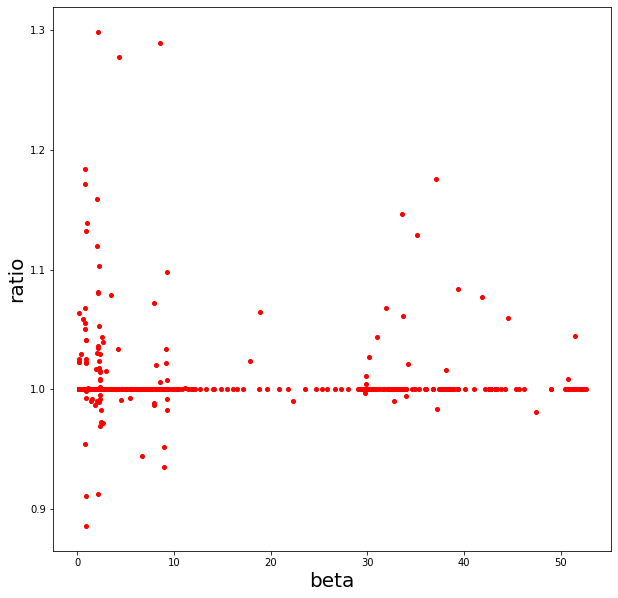

In [17]:
# beta and ratio
print(len(beta_mat))
print(len(record))

draw_data = []
for i in range(len(record)-1):
    draw_data.append([beta_mat[i+2,0], record[i+1]/record[i]])
draw_data = np.array(draw_data)
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(draw_data[:,0], draw_data[:,1], '.', markersize=8, c='red')
ax.set_xlabel('beta', {'size': 20})
ax.set_ylabel('ratio', {'size': 20})
plt.savefig('./test5.jpg')
plt.show()



In [23]:
import pandas as pd
 
# prepare for data
data_df = pd.DataFrame(draw_data)
 
# change the index and column name
data_df.columns = ['beta','ratio']
 
# create and writer pd.DataFrame to excel
writer = pd.ExcelWriter('Save_Excel.xlsx')
data_df.to_excel(writer,'sheet',float_format='%.5f') # float_format 控制精度
writer.save()

656
656


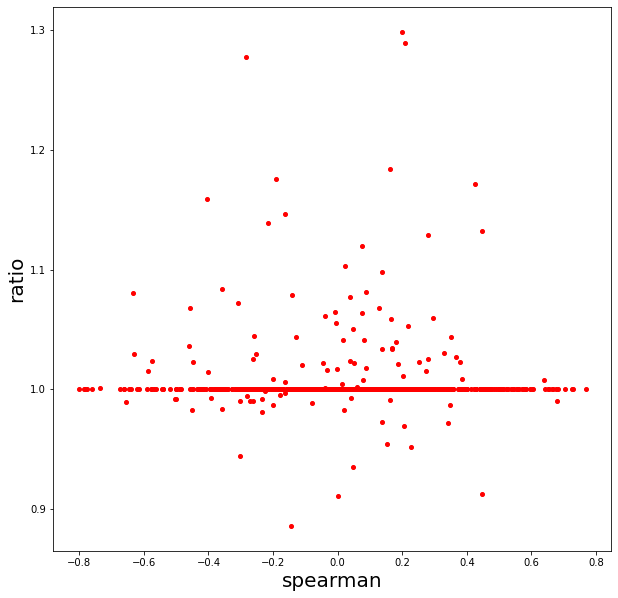

In [24]:
# spearman and ratio
print(len(spearman))
print(len(record))

draw_data = []
for i in range(len(record)-1):
    draw_data.append([spearman[i+1], record[i+1]/record[i]])
draw_data = np.array(draw_data)
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(draw_data[:,0], draw_data[:,1], '.', markersize=8, c='red')
ax.set_xlabel('spearman', {'size': 20})
ax.set_ylabel('ratio', {'size': 20})
plt.savefig('./test6.jpg')
plt.show()
writer.close()

In [ ]:
import pandas as pd
 
# prepare for data
data_df = pd.DataFrame(draw_data)
 
# change the index and column name
data_df.columns = ['spearman','ratio']
 
# create and writer pd.DataFrame to excel
writer = pd.ExcelWriter('spearman_ratio.xlsx')
data_df.to_excel(writer,'sheet',float_format='%.5f') # float_format 控制精度
writer.save()
writer.close()

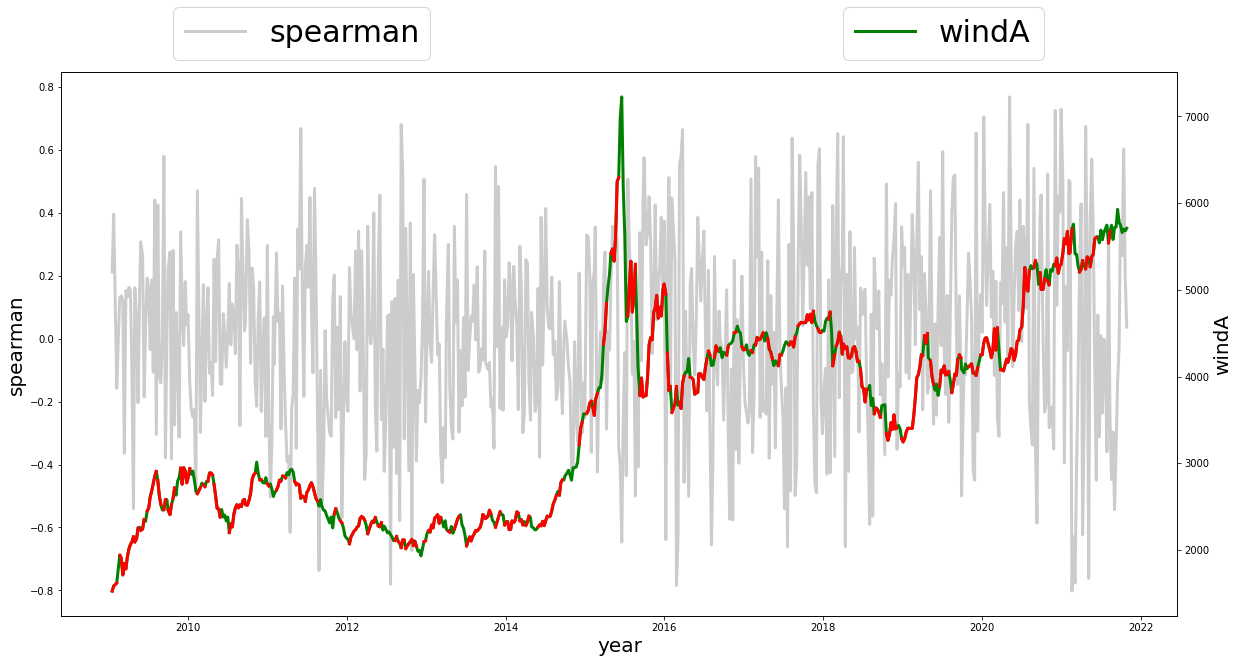

In [6]:
# 画图 spearman和windA

fig = plt.figure(figsize=(20, 10))
ax1 = plt.axes()
ax1.plot(dates, spearman, '-', c='black', lw=3, label='spearman', alpha=0.2)
plt.legend(prop={'size': 30}, bbox_to_anchor=(0.1, 1.02, 0.23, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)
ax2 = ax1.twinx()
ax2.plot(dates, wind[0:-1], '-', c='green', lw=3, label='windA', alpha=1.0)

for i in range(len(idxs)):
    ax2.plot(dates[idxs[i][0][0]:idxs[i][0][1]+1], wind[idxs[i][0][0]:idxs[i][0][1]+1], '-', c='red', lw=3, alpha=1.0)

plt.legend(prop={'size': 30}, bbox_to_anchor=(0.7, 1.02, 0.18, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)

ax1.set_xlabel('year', {'size': 20})
ax1.set_ylabel('spearman', {'size': 20})
ax2.set_ylabel('windA', {'size': 20})

plt.savefig('./test2.jpg')

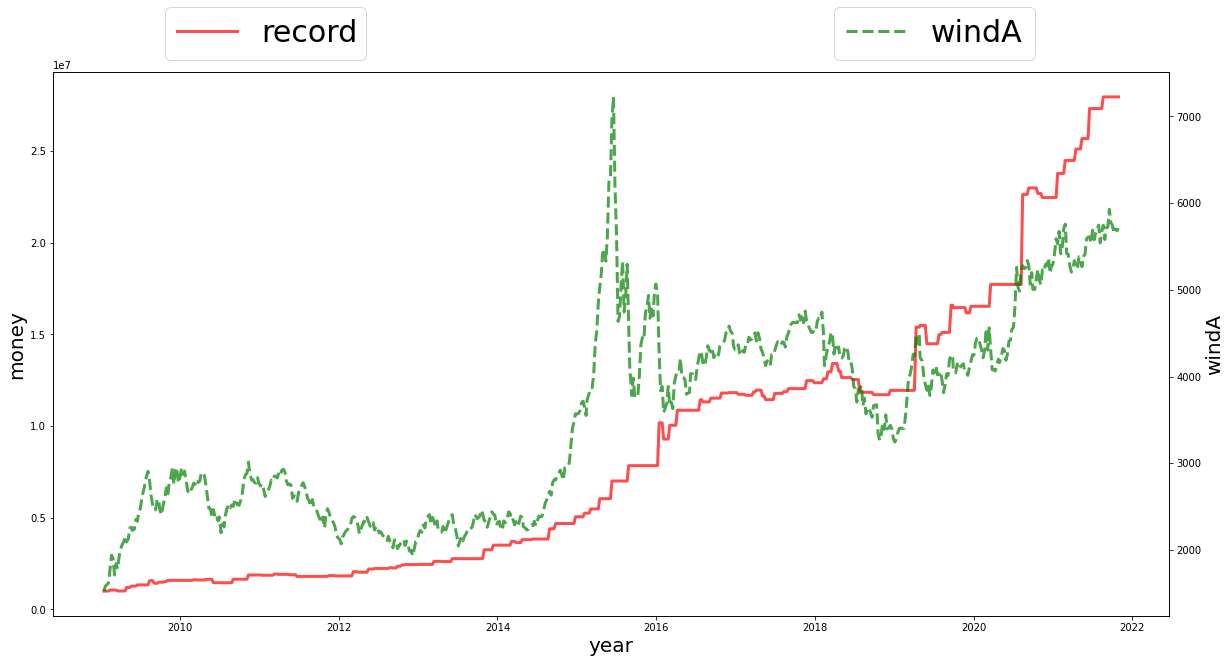

In [7]:
# 画图 赚的钱和windA

import matplotlib.pyplot as plt
wind_per = []
record_per = []
for i in wind[0:656]:
    wind_per.append(i)
for i in record:
    record_per.append(i)

fig = plt.figure(figsize=(20, 10))
ax1 = plt.axes()
ax1.plot(dates, record_per, c='red', lw=3, label='record', alpha=0.7)
plt.legend(prop={'size': 30}, bbox_to_anchor=(0.1, 1.02, 0.18, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)
ax2 = ax1.twinx()
ax2.plot(dates, wind_per, '--', c='green', lw=3, label='windA', alpha=0.7)
plt.legend(prop={'size': 30}, bbox_to_anchor=(0.7, 1.02, 0.18, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)

ax1.set_xlabel('year', {'size': 20})
ax1.set_ylabel('money', {'size': 20})
ax2.set_ylabel('windA', {'size': 20})

plt.savefig('./test3.jpg')